In [ ]:
from ucl.common import byte_print, decode_version, decode_sn, getVoltage, pretty_print_obj, lib_version
from ucl.lowState import lowState
from ucl.lowCmd import lowCmd
from ucl.unitreeConnection import unitreeConnection, LOW_WIFI_DEFAULTS, LOW_WIRED_DEFAULTS
from ucl.enums import GaitType, SpeedLevel, MotorModeLow
from ucl.complex import motorCmd, motorCmdArray
import time
import sys
import math
import numpy as np
from pprint import pprint


def jointLinearInterpolation(initPos, targetPos, rate):

    rate = np.fmin(np.fmax(rate, 0.0), 1.0)
    p = initPos*(1-rate) + targetPos*rate
    return p

# You can use one of the 3 Presets WIFI_DEFAULTS, LOW_CMD_DEFAULTS or HIGH_CMD_DEFAULTS.
# IF NONE OF THEM ARE WORKING YOU CAN DEFINE A CUSTOM ONE LIKE THIS:
#
# MY_CONNECTION_SETTINGS = (listenPort, addr_wifi, sendPort_high, local_ip_wifi)
# conn = unitreeConnection(MY_CONNECTION_SETTINGS)
d = {'FR_0':0, 'FR_1':1, 'FR_2':2,
     'FL_0':3, 'FL_1':4, 'FL_2':5,
     'RR_0':6, 'RR_1':7, 'RR_2':8,
     'RL_0':9, 'RL_1':10, 'RL_2':11 }

def printRobotStatus(conn,lstate):
    data = conn.getData()
    for paket in data:
        lstate.parseData(paket)
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        print(f'SN [{byte_print(lstate.SN)}]:\t{decode_sn(lstate.SN)}')
        print(f'Ver [{byte_print(lstate.version)}]:\t{decode_version(lstate.version)}')
        print(f'SOC:\t\t\t{lstate.bms.SOC} %')
        print(f'Overall Voltage:\t{getVoltage(lstate.bms.cell_vol)} mv') #something is still wrong here ?!
        print(f'Current:\t\t{lstate.bms.current} mA')
        print(f'Cycles:\t\t\t{lstate.bms.cycle}')
        print(f'Temps BQ:\t\t{lstate.bms.BQ_NTC[0]} °C, {lstate.bms.BQ_NTC[1]}°C')
        print(f'Temps MCU:\t\t{lstate.bms.MCU_NTC[0]} °C, {lstate.bms.MCU_NTC[1]}°C')
        print(f'FootForce:\t\t{lstate.footForce}')
        print(f'FootForceEst:\t\t{lstate.footForceEst}')
        print(f'IMU Temp:\t\t{lstate.imu.temperature}')
        print(f'MotorState FL_2 MODE:\t\t{lstate.motorState[d["FL_2"]].mode}')
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')



In [3]:
## Initialization ##
print(f'Running lib version: {lib_version()}')
conn = unitreeConnection(LOW_WIFI_DEFAULTS)
conn.startRecv()
lcmd = lowCmd()
# lcmd.encrypt = True
lstate = lowState()
mCmdArr = motorCmdArray()
# Send empty command to tell the dog the receive port and initialize the connection
cmd_bytes = lcmd.buildCmd(debug=False)
conn.send(cmd_bytes)
lstate = printRobotStatus(conn,lstate)

Running lib version: 0.2


In [18]:
data = conn.getData()

Number of data packets received in 15 seconds: 3168
Mean interval: 0.004734s, Mean rate: 211.26 Hz


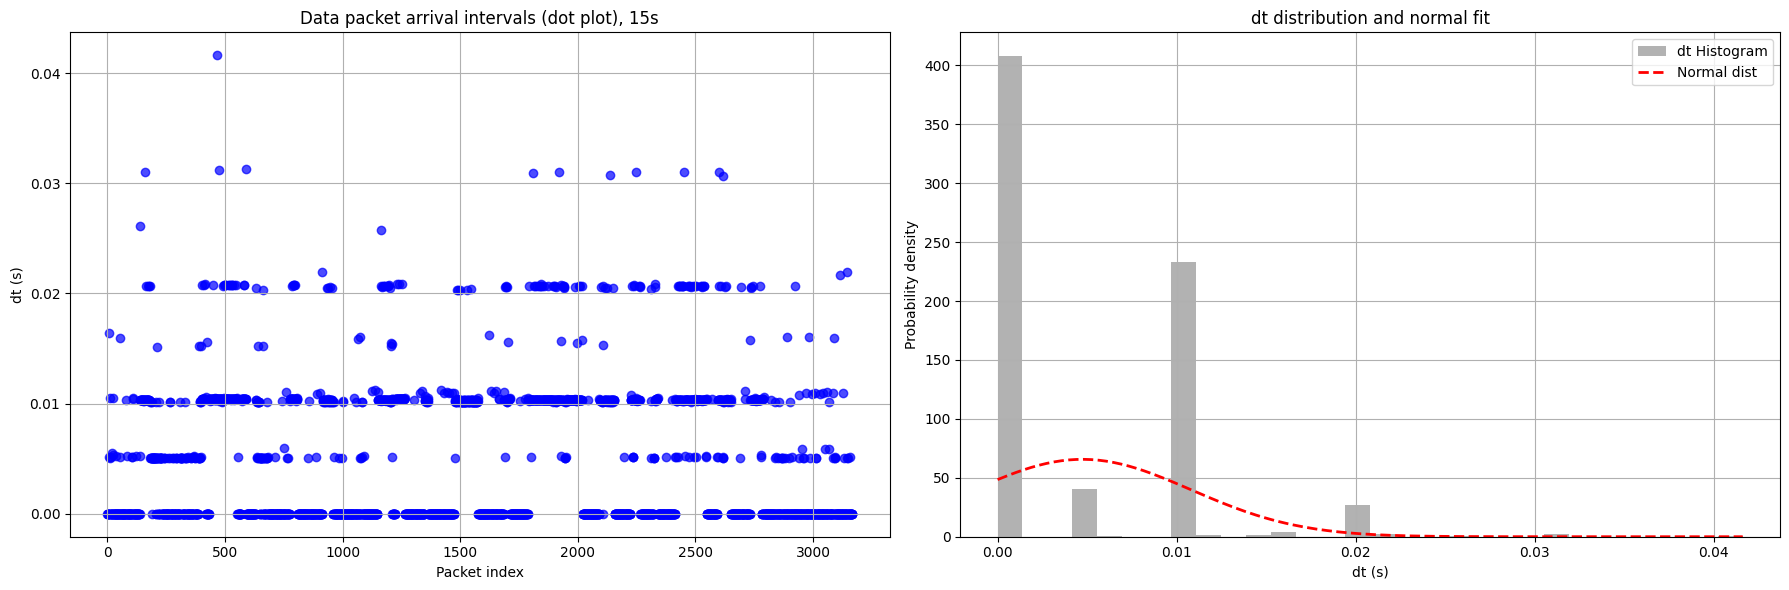

In [ ]:
# 데이터 수신 속도(초당 몇 줄)의 구성을 위한 코드 (점 그래프 및 정규분포 분산 그래프 포함)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

sample_duration = 15  # 측정할 시간(초)
dt_list = []

# 첫 루프에서 데이터 버리기 (버퍼 청소)
conn.getData()

start_time = time.time()
last_time = start_time

while True:
    loop_data = conn.getData()
    now = time.time()
    if loop_data:
        # 데이터가 있을 때마다 dt 측정
        for _ in loop_data:
            dt = now - last_time
            if len(dt_list) == 0:
                # 첫 데이터라면 dt 0으로
                dt_list.append(0)
            else:
                dt_list.append(dt)
            last_time = now
    if now - start_time >= sample_duration:
        break
    # 쉬는시간 없이, 바로 다음 루프로

print(f"Number of data packets received in {sample_duration} seconds: {len(dt_list)}")
if len(dt_list) > 1:
    print(f"Mean interval: {sum(dt_list[1:])/len(dt_list[1:]):.6f}s, Mean rate: {1/(sum(dt_list[1:])/len(dt_list[1:])):.2f} Hz")

# dt_list visualization (scatter plot + histogram/normal distribution fit)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# 1. Scatter plot: interval (dt) for each data packet
ax1.scatter(range(len(dt_list)), dt_list, color='b', alpha=0.7)
ax1.set_xlabel('Packet index')
ax1.set_ylabel('dt (s)')
ax1.set_title(f'Data packet arrival intervals (dot plot), {sample_duration}s')
ax1.grid(True)

# 2. Histogram and normal distribution curve
dt_arr = np.array(dt_list[1:])  # skip the first dt=0
if len(dt_arr) > 0:
    mu = np.mean(dt_arr)
    sigma = np.std(dt_arr)
    n, bins, patches = ax2.hist(dt_arr, bins=30, density=True, alpha=0.6, color='gray', label='dt Histogram')
    x = np.linspace(dt_arr.min(), dt_arr.max(), 200)
    pdf = norm.pdf(x, mu, sigma)
    ax2.plot(x, pdf, 'r--', linewidth=2, label='Normal dist')
    ax2.set_xlabel('dt (s)')
    ax2.set_ylabel('Probability density')
    ax2.set_title('dt distribution and normal fit')
    ax2.legend()
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'No dt data to plot', ha='center', va='center')

plt.tight_layout()
plt.show()


In [4]:
def printRobotStatusNow(conn,lstate):
    data = conn.getData()
    if data:
        lstate.parseData(data[-1]) # Process the last packet ONLY
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        print(f'SN [{byte_print(lstate.SN)}]:\t{decode_sn(lstate.SN)}')
        print(f'Ver [{byte_print(lstate.version)}]:\t{decode_version(lstate.version)}')
        print(f'SOC:\t\t\t{lstate.bms.SOC} %')
        print(f'Overall Voltage:\t{getVoltage(lstate.bms.cell_vol)} mv') #something is still wrong here ?!
        print(f'Current:\t\t{lstate.bms.current} mA')
        print(f'Cycles:\t\t\t{lstate.bms.cycle}')
        print(f'Temps BQ:\t\t{lstate.bms.BQ_NTC[0]} °C, {lstate.bms.BQ_NTC[1]}°C')
        print(f'Temps MCU:\t\t{lstate.bms.MCU_NTC[0]} °C, {lstate.bms.MCU_NTC[1]}°C')
        print(f'FootForce:\t\t{lstate.footForce}')
        print(f'FootForceEst:\t\t{lstate.footForceEst}')
        print(f'IMU Temp:\t\t{lstate.imu.temperature}')
        print(f'IMU RPY:\t\tRoll={lstate.imu.rpy[0]:.3f}, Pitch={lstate.imu.rpy[1]:.3f}, Yaw={lstate.imu.rpy[2] :.3f}')
        print(f'MotorState FL_2 MODE:\t\t{lstate.motorState[d["FL_2"]].mode}')
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
    
    # Return the last packet's state
    return lstate

In [ ]:
printRobotStatusNow(conn,lstate)

AttributeError: 'NoneType' object has no attribute 'parseData'

In [8]:
data = conn.getData()
data

[]

In [37]:
while True:
    lstate = printRobotStatusNow(conn,lstate)
    time.sleep(0.01)

AttributeError: 'NoneType' object has no attribute 'parseData'

In [9]:
from ucl.common import byte_print, decode_version, decode_sn, getVoltage, pretty_print_obj, lib_version
from ucl.lowState import lowState
from ucl.lowCmd import lowCmd
from ucl.unitreeConnection import unitreeConnection, LOW_WIFI_DEFAULTS, LOW_WIRED_DEFAULTS
from ucl.enums import GaitType, SpeedLevel, MotorModeLow
from ucl.complex import motorCmd, motorCmdArray
import time
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import glob

## Utility functions for file management
def ensure_logs_directory():
    """Create logs directory if it doesn't exist"""
    if not os.path.exists('logs'):
        os.makedirs('logs')
        print("Created 'logs' directory")

def get_timestamp_filename(base_name, extension):
    """Generate filename with timestamp prefix"""
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    return f"{timestamp}_{base_name}.{extension}"

def get_latest_csv_file():
    """Get the most recent CSV file from logs directory"""
    ensure_logs_directory()
    csv_pattern = os.path.join('logs', '*_joint_tracking_data.csv')
    csv_files = glob.glob(csv_pattern)
    
    if not csv_files:
        print("No CSV files found in logs directory")
        return None
    
    # Sort by filename (timestamp) in descending order
    csv_files.sort(reverse=True)
    latest_file = csv_files[0]
    print(f"Latest CSV file: {latest_file}")
    return latest_file

## Modularized plotting function for joint tracking analysis
def print_timing_drift_statistics(timing_drifts, actual_loop_times, ctrldt):
    """
    타이밍 드리프트 분석 통계를 출력하는 함수
    
    Args:
        timing_drifts (list): 타이밍 드리프트 데이터 (ms 단위)
        actual_loop_times (list): 실제 루프 시간 데이터 (ms 단위)
        ctrldt (float): 제어 주기 (초)
    """
    if len(timing_drifts) == 0:
        print("타이밍 드리프트 데이터가 없습니다.")
        return
    
    print("\n=== 타이밍 Drift 분석 통계 ===")
    avg_drift = np.mean(timing_drifts)
    max_drift = np.max(timing_drifts)
    min_drift = np.min(timing_drifts)
    std_drift = np.std(timing_drifts)
    
    avg_loop_time = np.mean(actual_loop_times)
    actual_freq = 1000 / avg_loop_time  # Hz
    
    print(f"평균 Drift: {avg_drift:.3f} ms")
    print(f"최대 Drift: {max_drift:.3f} ms")
    print(f"최소 Drift: {min_drift:.3f} ms")
    print(f"Drift 표준편차: {std_drift:.3f} ms")
    print(f"평균 실제 루프 주기: {avg_loop_time:.3f} ms")
    print(f"실제 제어 주파수: {actual_freq:.2f} Hz (목표: {1/ctrldt:.2f} Hz)")
    print(f"주파수 오차: {abs(actual_freq - 1/ctrldt):.2f} Hz")
    
    # Drift 분포 분석
    positive_drifts = [d for d in timing_drifts if d > 0]
    negative_drifts = [d for d in timing_drifts if d < 0]
    print(f"양수 Drift 비율: {len(positive_drifts)/len(timing_drifts)*100:.1f}%")
    print(f"음수 Drift 비율: {len(negative_drifts)/len(timing_drifts)*100:.1f}%")

def plot_joint_positions_from_csv(csv_file_path, output_file=None):
    """
    CSV 파일에서 joint position 데이터를 읽어서 플롯 생성
    
    Args:
        csv_file_path (str): CSV 파일 경로
        output_file (str, optional): 출력 이미지 파일 경로. None이면 화면에 표시만 함.
    """
    if not os.path.exists(csv_file_path):
        print(f"CSV 파일을 찾을 수 없습니다: {csv_file_path}")
        return
    
    # CSV 데이터 읽기
    df = pd.read_csv(csv_file_path)
    
    # Joint 이름 추출 (position 컬럼에서)
    position_cols = [col for col in df.columns if col.endswith('_position')]
    joint_names = [col.replace('_position', '') for col in position_cols]
    jointnum = len(joint_names)
    
    if jointnum == 0:
        print("CSV 파일에서 joint 데이터를 찾을 수 없습니다.")
        return
    
    # 시간 데이터 추출 (실제 시간 사용)
    if 'real_time' in df.columns:
        time_array = df['real_time'].values
        time_label = 'Real Time (s)'
    elif 'timestamp' in df.columns:
        time_array = df['timestamp'].values
        time_label = 'Time (s)'
    else:
        print("시간 데이터를 찾을 수 없습니다.")
        return
    
    # Create 3x4 subplot grid
    fig, axes = plt.subplots(3, 4, figsize=(40, 15))
    fig.suptitle('Joint Position Analysis', fontsize=20)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Plot each joint
    for i in range(jointnum):
        ax = axes_flat[i]
        
        # Get position data
        position_col = f'{joint_names[i]}_position'
        
        if position_col in df.columns:
            position_data = df[position_col].values
            
            # Plot joint positions
            ax.plot(time_array, position_data, 'b-', label='Position', linewidth=2)
            
            # Set labels and title
            ax.set_title(f'{joint_names[i]} Position', fontsize=14)
            ax.set_xlabel(time_label)
            ax.set_ylabel('Position (deg)')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right')
            
            # Calculate and display statistics
            mean_pos = np.mean(position_data)
            std_pos = np.std(position_data)
            min_pos = np.min(position_data)
            max_pos = np.max(position_data)
            ax.text(0.02, 0.98, f'Mean: {mean_pos:.2f}°\nStd: {std_pos:.2f}°\nRange: [{min_pos:.2f}, {max_pos:.2f}]°', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax.text(0.5, 0.5, f'No data for {joint_names[i]}', 
                   transform=ax.transAxes, ha='center', va='center')
    
    # Hide unused subplots
    for i in range(jointnum, 12):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"플롯이 '{output_file}'로 저장되었습니다.")
    
    plt.show()
    
    # Print overall statistics
    print("\n=== 전체 관절 위치 통계 ===")
    for i in range(jointnum):
        position_col = f'{joint_names[i]}_position'
        if position_col in df.columns:
            position_data = df[position_col].values
            mean_pos = np.mean(position_data)
            std_pos = np.std(position_data)
            min_pos = np.min(position_data)
            max_pos = np.max(position_data)
            print(f"{joint_names[i]}: Mean={mean_pos:.2f}°, Std={std_pos:.2f}°, Range=[{min_pos:.2f}, {max_pos:.2f}]°")

def plot_joint_tracking_from_csv(csv_file_path, output_file=None):
    """
    CSV 파일에서 joint tracking 데이터를 읽어서 플롯 생성
    
    Args:
        csv_file_path (str): CSV 파일 경로
        output_file (str, optional): 출력 이미지 파일 경로. None이면 화면에 표시만 함.
    """
    if not os.path.exists(csv_file_path):
        print(f"CSV 파일을 찾을 수 없습니다: {csv_file_path}")
        return
    
    # CSV 데이터 읽기
    df = pd.read_csv(csv_file_path)
    
    # Joint 이름 추출 (target 컬럼에서)
    target_cols = [col for col in df.columns if col.endswith('_target')]
    joint_names = [col.replace('_target', '') for col in target_cols]
    jointnum = len(joint_names)
    
    if jointnum == 0:
        print("CSV 파일에서 joint 데이터를 찾을 수 없습니다.")
        return
    
    # 시간 데이터 추출 (실제 시간 사용)
    if 'real_time' in df.columns:
        time_array = df['real_time'].values
        time_label = 'Real Time (s)'
    elif 'timestamp' in df.columns:
        time_array = df['timestamp'].values
        time_label = 'Time (s)'
    else:
        print("시간 데이터를 찾을 수 없습니다.")
        return
    
    # Create 3x4 subplot grid with doubled width
    fig, axes = plt.subplots(3, 4, figsize=(40, 15))  # 2배 폭으로 증가
    fig.suptitle('Joint Tracking Performance Analysis', fontsize=20)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Plot each joint
    for i in range(jointnum):
        ax = axes_flat[i]
        
        # Get target and actual data
        target_col = f'{joint_names[i]}_target'
        actual_col = f'{joint_names[i]}_actual'
        
        if target_col in df.columns and actual_col in df.columns:
            target_data = df[target_col].values
            actual_data = df[actual_col].values
            
            # Plot target and actual positions
            ax.plot(time_array, target_data, 'b-', label='Target', linewidth=2)
            ax.plot(time_array, actual_data, 'r-', label='Actual', linewidth=1.5)
            
            # Calculate tracking error
            error = actual_data - target_data
            ax2 = ax.twinx()
            ax2.plot(time_array, error, 'g--', label='Error', alpha=0.7)
            ax2.set_ylabel('Error (deg)', color='g')
            ax2.tick_params(axis='y', labelcolor='g')
            
            # Set labels and title
            ax.set_title(f'{joint_names[i]} Tracking Performance', fontsize=14)
            ax.set_xlabel(time_label)
            ax.set_ylabel('Position (deg)')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right')
            
            # Calculate and display statistics
            rmse = np.sqrt(np.mean(error**2))
            max_error = np.max(np.abs(error))
            ax.text(0.02, 0.98, f'RMSE: {rmse:.2f}°\nMax Error: {max_error:.2f}°', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        else:
            ax.text(0.5, 0.5, f'No data for {joint_names[i]}', 
                   transform=ax.transAxes, ha='center', va='center')
    
    # Hide unused subplots
    for i in range(jointnum, 12):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"플롯이 '{output_file}'로 저장되었습니다.")
    
    plt.show()
    
    # Print overall statistics
    print("\n=== 전체 추종 성능 통계 ===")
    for i in range(jointnum):
        target_col = f'{joint_names[i]}_target'
        actual_col = f'{joint_names[i]}_actual'
        if target_col in df.columns and actual_col in df.columns:
            error = df[actual_col].values - df[target_col].values
            rmse = np.sqrt(np.mean(error**2))
            max_error = np.max(np.abs(error))
            print(f"{joint_names[i]}: RMSE={rmse:.2f}°, Max Error={max_error:.2f}°")

# Joint mapping dictionary
d = {'FR_0':0, 'FR_1':1, 'FR_2':2,
     'FL_0':3, 'FL_1':4, 'FL_2':5,
     'RR_0':6, 'RR_1':7, 'RR_2':8,
     'RL_0':9, 'RL_1':10, 'RL_2':11 }

## Define constants
PosStopF  = math.pow(10,9)
VelStopF  = 16000.0
LOWLEVEL  = 0xff

## Initialize connection
print(f'Running lib version: {lib_version()}')
conn = unitreeConnection(LOW_WIFI_DEFAULTS)
conn.startRecv()

## Instantiate lowlevel command and state objects
lcmd = lowCmd()
lstate = lowState()
mCmdArr = motorCmdArray()

## Get initial state & print Log
# Send empty command to tell the dog the receive port and initialize the connection
cmd_bytes = lcmd.buildCmd(debug=False)
conn.send(cmd_bytes)

def printLog(conn,lstate):
    """Print robot state information"""
    data = conn.getData()
    try:
        paket = data[-1]  # Try to process only the latest packet
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
        lstate.parseData(paket)
        print(f'SN [{byte_print(lstate.SN)}]:\t{decode_sn(lstate.SN)}')
        print(f'Ver [{byte_print(lstate.version)}]:\t{decode_version(lstate.version)}')
        print(f'SOC:\t\t\t{lstate.bms.SOC} %')
        print(f'Overall Voltage:\t{getVoltage(lstate.bms.cell_vol)} mv')
        print(f'Current:\t\t{lstate.bms.current} mA')
        print(f'Cycles:\t\t\t{lstate.bms.cycle}')
        print(f'Temps BQ:\t\t{lstate.bms.BQ_NTC[0]} °C, {lstate.bms.BQ_NTC[1]}°C')
        print(f'Temps MCU:\t\t{lstate.bms.MCU_NTC[0]} °C, {lstate.bms.MCU_NTC[1]}°C')
        print(f'FootForce:\t\t{lstate.footForce}')
        print(f'FootForceEst:\t\t{lstate.footForceEst}')
        print(f'IMU Temp:\t\t{lstate.imu.temperature}')
        print(f'MotorState FR_0 MODE:\t\t{lstate.motorState[d["FR_0"]].mode}')
        print('+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=')
    except Exception as e:
        print(f"데이터 처리 중 오류 발생: {e}")

# 12개 관절의 각도(q)를 radian 단위의 리스트로 리턴하는 함수
def get_joint_angles_rad(conn,lstate,joint):
    """
    conn에서 최신 패킷을 받아 12개 관절의 각도(q, radian) 리스트를 반환

    Returns:
        q_list (list): 12개 관절의 각도 리스트 (radian, joint 순서는 global 'joint' 리스트와 동일)
                       오류시 None 반환
    """
    joint = ['FR_0', 'FR_1', 'FR_2', 'FL_0', 'FL_1', 'FL_2', 'RL_0', 'RL_1', 'RL_2', 'RR_0', 'RR_1', 'RR_2']

    data = conn.getData()
    try:
        paket = data[-1]  # 최신 패킷만 처리
        lstate.parseData(paket)
        # 관절 이름이 'joint' 리스트에 있다고 가정
        q_list = [lstate.motorState[d[jname]].q for jname in joint]
        return q_list
    except Exception as e:
        print(f"관절 각도 읽기 오류: {e}")
        return None



Running lib version: 0.2


In [10]:
printLog(conn,lstate)

+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
SN [0402020419020d00]:	('Go1_PRO', '2-4-25[2]')
Ver [000109000130fa7f]:	('0.1.9', '0.1.48')
SOC:			19 %
Overall Voltage:	21024 mv
Current:		-1717 mA
Cycles:			79
Temps BQ:		35 °C, 33°C
Temps MCU:		34 °C, 38°C
FootForce:		[898, 0, 0, 45085]
FootForceEst:		[0, 20821, 0, 23208]
IMU Temp:		79
MotorState FR_0 MODE:		0
+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=
